![A soccer pitch for an international match.](soccer-pitch.jpg)

***Scenario:*** You're working as a sports journalist at a major online sports media company, specializing in soccer analysis and reporting. You've been watching both men's and women's international soccer matches for a number of years, and your gut instinct tells you that more goals are scored in women's international football matches than men's. This would make an interesting investigative article that your subscribers are bound to love, but you'll need to perform a valid statistical hypothesis test to be sure!

While scoping this project, you acknowledge that the sport has changed a lot over the years, and performances likely vary a lot depending on the tournament, so you decide to limit the data used in the analysis to only official `FIFA World Cup` matches (not including qualifiers) since `2002-01-01`.

You create two datasets containing the results of every official men's and women's international football match since the 19th century, which you scraped from a reliable online source. This data is stored in two CSV files: `women_results.csv` and `men_results.csv`.

The question we are trying to determine the answer to is:

> Are more goals scored in women's international soccer matches than men's?

You assume a **10% significance level**, and use the following null and alternative hypotheses:

$H_0$ : The mean number of goals scored in women's international soccer matches is the same as men's.

$H_A$ : The mean number of goals scored in women's international soccer matches is greater than men's.

In [1]:
import pandas as pd

# read data
df_men_socc = pd.read_csv('./data/men_results.csv')
df_women_socc = pd.read_csv('./data/women_results.csv')
# drop the redundant index column
df_men_socc.drop('Unnamed: 0', axis='columns', inplace=True)
df_women_socc.drop('Unnamed: 0', axis='columns', inplace=True)
# remove all rows before 2002-01-01
df_men = df_men_socc.loc[df_men_socc['date'] >= '2002-01-01'].copy()
df_women = df_women_socc.loc[df_women_socc['date'] >= '2002-01-01'].copy()
# total goals scored needed for comparison
df_men["total_goals"] = df_men['home_score'] + df_men['away_score']
df_women["total_goals"] = df_women['home_score'] + df_women['away_score']
# add gender column which will be needed after the 2 df's are combined
df_men['gender'] = "men"
df_women['gender'] = "women"

print(df_men.describe(), '\n')
print(df_women.describe(), '\n')

df_women.head()

         home_score    away_score   total_goals
count  19490.000000  19490.000000  19490.000000
mean       1.613905      1.099795      2.713699
std        1.655043      1.346312      1.939837
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      1.000000
50%        1.000000      1.000000      2.000000
75%        2.000000      2.000000      4.000000
max       21.000000     21.000000     22.000000 

        home_score   away_score  total_goals
count  3519.000000  3519.000000  3519.000000
mean      2.094913     1.460358     3.555271
std       2.437992     1.992326     2.578996
min       0.000000     0.000000     0.000000
25%       0.000000     0.000000     2.000000
50%       1.000000     1.000000     3.000000
75%       3.000000     2.000000     5.000000
max      21.000000    24.000000    26.000000 



,date,home_team,away_team,home_score,away_score,tournament,total_goals,gender
1365,2002-01-23,Norway,United States,1,0,Four Nations Tournament,1,women
1366,2002-01-23,China PR,Germany,2,1,Four Nations Tournament,3,women
1367,2002-01-25,Germany,United States,0,0,Four Nations Tournament,0,women
1368,2002-01-25,China PR,Norway,0,3,Four Nations Tournament,3,women
1369,2002-01-27,Germany,Norway,3,1,Four Nations Tournament,4,women


## Types of tournaments

As described above, **qualifiers** need to be filtered out, so let's start by looking at tournament types before and after filtering:

In [2]:
def tournament_types(df, gender='women', col_name='tournament', qual_flag='qualification'):
    """ Calculates the counts of tournament types and filters out the qualifying matches
    from df

    Args:
      df (pandas dataframe): dataframe with columns specified by gender, col_name and qual_flag
      gender (str): allowable values "women" or "men"
      col_name (str): column where the tournament type if stored, default: "tournament"
      qual_flag (str): substring in the col_name field that identifies the match as a
                 qualification match, default: "qualification"

    Returns:
      dict: with 2 keys "tournaments" and "non_quals". The value for the "tournaments" key
            is a Series with index values that are the all tournament types. The value
            for the "non_quals" key is the passed in df with all qualification matches
            filtered out
    
    """
    tournaments = df[col_name].value_counts()
    is_qual = tournaments.index.str.contains(qual_flag)
    non_quals = tournaments[~is_qual]
    print(is_qual, '\n')
    print(tournaments, '\n')
    print(non_quals, '\n')
    print(f"total count of {gender} tournament types BEFORE filtering: {len(tournaments)}")
    print(f"total count of {gender} tournament types  AFTER filtering: {len(non_quals)} \n")

    return {'tournaments': tournaments,
            'non_quals': non_quals}

women_non_quals = tournament_types(df=df_women)['non_quals']

[ True False False  True False  True  True False False  True False False
 False False False False  True False False False False False  True False
 False  True False] 

tournament
UEFA Euro qualification                 856
Algarve Cup                             430
Cyprus Cup                              258
African Championship qualification      211
FIFA World Cup                          200
FIFA World Cup qualification            172
AFC Asian Cup qualification             141
African Championship                    128
UEFA Euro                               127
CONCACAF Gold Cup qualification         127
Friendly                                111
AFC Asian Cup                           111
CONCACAF Gold Cup                       110
Four Nations Tournament                 100
Olympic Games                            98
Copa América                             93
African Cup of Nations qualification     58
SheBelieves Cup                          39
OFC Championship             

In [3]:
men_non_quals = tournament_types(df=df_men, gender='men')['non_quals']

[False  True  True  True False  True False False False False  True False
 False False False False False False False False False False False False
 False  True False False False False  True  True False  True False False
 False False False False False False False False False False False False
 False False False  True False False False  True False  True False False
 False False False False False False False False False  True False False
 False False False False False  True False False False False False] 

tournament
Friendly                                6825
FIFA World Cup qualification            4168
UEFA Euro qualification                 1293
African Cup of Nations qualification     910
UEFA Nations League                      468
                                        ... 
Atlantic Heritage Cup                      2
Copa Paz del Chaco                         2
TIFOCO Tournament                          1
Copa Confraternidad                        1
CONMEBOL–UEFA Cup of Champions 

## Goal distributions

Before selecting a test to test our hypothesis, let's looks at the shape of the total goals distributions. It is not obvious from the visual below that women matches score more goals on average. We can also see that these distributions clearlly are **not** normal which we knew in advance to be case because it is a discrete distribution with the left side being bounded by zero (i.e. can not go below zero).

Because of the data is not normally distributed, a non-parametric test such as the ***Mann-Whitney U Test*** makes sense here.

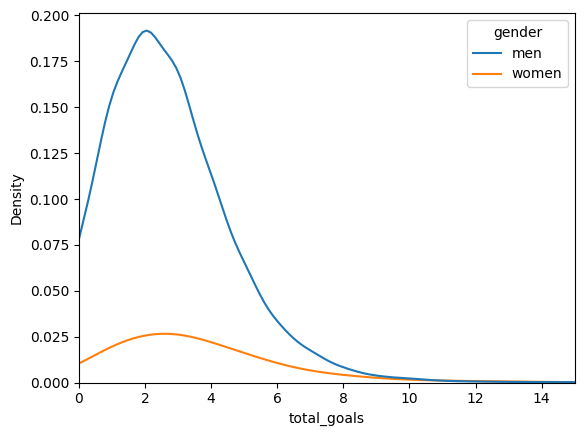

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

df_all = pd.concat([df_men, df_women], ignore_index = True)

sns.kdeplot(data=df_all,
            x='total_goals',
            hue='gender',
            bw_adjust=2)

plt.xlim(0, 15)
plt.show()

In [5]:
from scipy.stats import mannwhitneyu

alpha = 0.10

stat, p_val = mannwhitneyu(
    df_all[df_all['gender'] == 'women']['total_goals'],
    df_all[df_all['gender'] == 'men']['total_goals'],
    alternative='greater'  # HA: women score more goals
)

def test_hypothesis(alpha, p_val):
    if p_val < alpha:
        result = "reject"
    else:
        result = "fail to reject"

    return {"p_val": p_val, "result": result}

result_dict = test_hypothesis(alpha, p_val)

print(f"Mann-Whitney U test p-value: {result_dict['p_val']}")
print(f"At alpha = {alpha}, we {result_dict['result']} the null hypothesis that means are the same in favor of the alternative hypothesis")

Mann-Whitney U test p-value: 7.703140811178407e-75
At alpha = 0.1, we reject the null hypothesis that means are the same in favor of the alternative hypothesis
